# 05 - Comparison of Finite Volume & Spectral Methods

Run a passive scalar simulation driven by a synthetic velocity field with two numerical methods and compare them.

**Workflow**
- Configure the simulator and generate a velocity field
- Evolve a scalar distribution with ETDRK4
- Explore diagnostics, scalar spectra, and dissipation

In [1]:
import sys, pathlib
project_root = pathlib.Path().resolve()
if not (project_root / 'scalar_advection').exists():
    for parent in project_root.parents:
        if (parent / 'scalar_advection').exists():
            project_root = parent
            break
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scalar_advection import ScalarAdvectionAPI, VelocityConfig, ScalarConfig

## Set up the simulation

In [4]:
api = ScalarAdvectionAPI(N=256, L=1.0)
velocity_config = VelocityConfig(beta=5/3, urms=1.0, seed=11, method ="finite_volume")
ux, uy = api.generate_velocity(velocity_config)

theta0 = api.circle_initial_condition(radius=0.25)

scalar_config_sp = ScalarConfig(
    peclet=500,
    t_end=0.3,
    save_every=20,
    mean_grad=(1.0, 0.0),
)

scalar_config_fv = ScalarConfig(
    peclet=500,
    t_end=0.3,
    save_every=20,
    mean_grad=(1.0, 0.0),
    method="finite_volume",
)

theta_final_sp, sp_diagnostics = api.evolve_scalar(theta0, ux, uy, scalar_config_sp, verbose=False)
theta_final_fv, fv_diagnostics = api.evolve_scalar(theta0, ux, uy, scalar_config_fv, verbose=False)


### Simulation summary

In [5]:
print("Spectral Method Diagnostics")
print(f'Time steps: {sp_diagnostics.n_steps}')
print(f'Delta t: {sp_diagnostics.dt:.4e}')
print(f'Diffusivity kappa: {sp_diagnostics.kappa:.3e}')
print(f'Snapshots stored: {len(sp_diagnostics.snapshots)}')
print(f'Frame stack available: {sp_diagnostics.frames is not None}')

print("\nFinite Volume Method Diagnostics")
print(f'Time steps: {fv_diagnostics.n_steps}')
print(f'Delta t: {fv_diagnostics.dt:.4e}')
print(f'Diffusivity kappa: {fv_diagnostics.kappa:.3e}')
print(f'Snapshots stored: {len(fv_diagnostics.snapshots)}')
print(f'Frame stack available: {fv_diagnostics.frames is not None}')

Spectral Method Diagnostics
Time steps: 768
Delta t: 3.9062e-04
Diffusivity kappa: 2.000e-03
Snapshots stored: 40
Frame stack available: False

Finite Volume Method Diagnostics
Time steps: 768
Delta t: 3.9062e-04
Diffusivity kappa: 2.000e-03
Snapshots stored: 40
Frame stack available: False


### Visualise initial and final scalar fields

In [6]:
(L,N,dx) = (api.grid.L, api.grid.N, api.grid.dx)
x = np.linspace((-L + dx)/2, (L-dx)/2, N)
y = np.linspace((-L + dx)/2, (L-dx)/2, N)
(X,Y) = np.meshgrid(x,y, indexing='xy')
ext = (-L/2, L/2, -L/2, L/2)

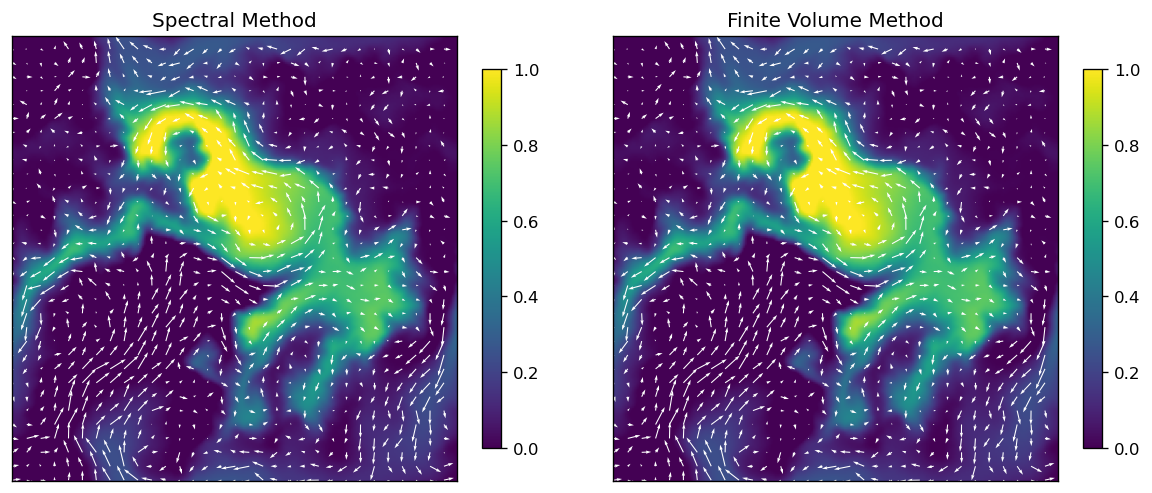

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120, constrained_layout=True)

# controls how spaced out the quiver arrows are, smaller number = more arrows
nj = 8

im0 = axs[0].imshow(theta_final_sp, origin='lower', cmap='viridis', extent=ext, vmin=theta0.min(), vmax=theta0.max())
axs[0].set_title('Spectral Method')
axs[0].quiver(X[::nj,::nj], Y[::nj,::nj], ux[::nj,::nj], uy[::nj,::nj], color='w')
plt.colorbar(im0, ax=axs[0], shrink=0.85)

im1 = axs[1].imshow(theta_final_fv, origin='lower', cmap='viridis', extent=ext, vmin=theta0.min(), vmax=theta0.max())
axs[1].set_title('Finite Volume Method')
axs[1].quiver(X[::nj,::nj], Y[::nj,::nj], ux[::nj,::nj], uy[::nj,::nj], color='w')
plt.colorbar(im1, ax=axs[1], shrink=0.85)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Snapshot timeline

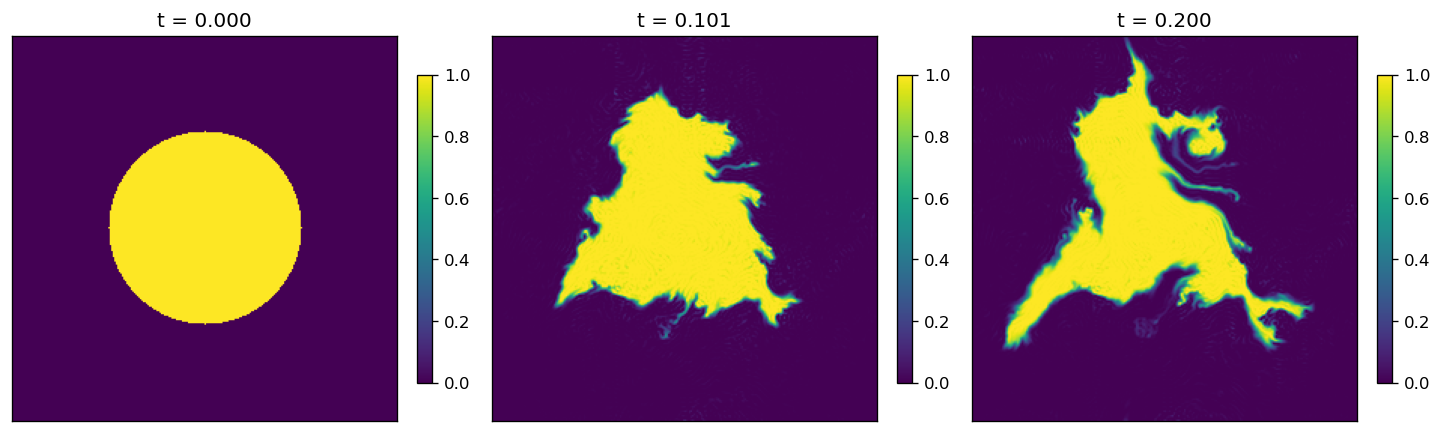

In [9]:
if diagnostics.snapshots:
    idxs = np.linspace(0, len(diagnostics.snapshots) - 1, 3, dtype=int)
    fig, axs = plt.subplots(1, len(idxs), figsize=(12, 3.5), dpi=120, constrained_layout=True)
    for ax, idx in zip(axs, idxs):
        im = ax.imshow(diagnostics.snapshots[idx], origin='lower', cmap='viridis',vmin=theta0.min(), vmax=theta0.max(), extent=ext)
        ax.set_title(f't = {diagnostics.times[idx]:.3f}')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, shrink=0.8)
    plt.show()
else:
    print('No in-memory snapshots stored (save_every=None).')

### Scalar dissipation

In [15]:
chi = api.scalar_dissipation(theta_final, diagnostics.kappa)
print(f'Scalar dissipation rate chi = {chi:.3e}')

Scalar dissipation rate chi = 1.812e-01


### Scalar spectra

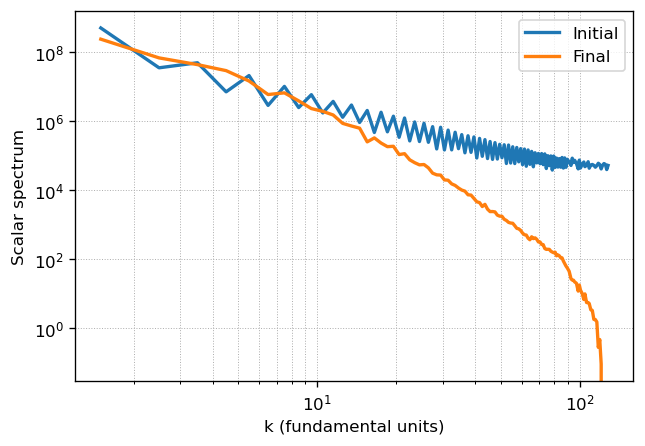

In [16]:
spec_init = api.scalar_spectrum(theta0)
spec_final = api.scalar_spectrum(theta_final)
plt.figure(figsize=(6, 4), dpi=120)
plt.loglog(spec_init.k, spec_init.Pk, label='Initial', lw=2)
plt.loglog(spec_final.k, spec_final.Pk, label='Final', lw=2)
plt.xlabel('k (fundamental units)')
plt.ylabel('Scalar spectrum')
plt.grid(True, which='both', ls=':', lw=0.6)
plt.legend()
plt.show()

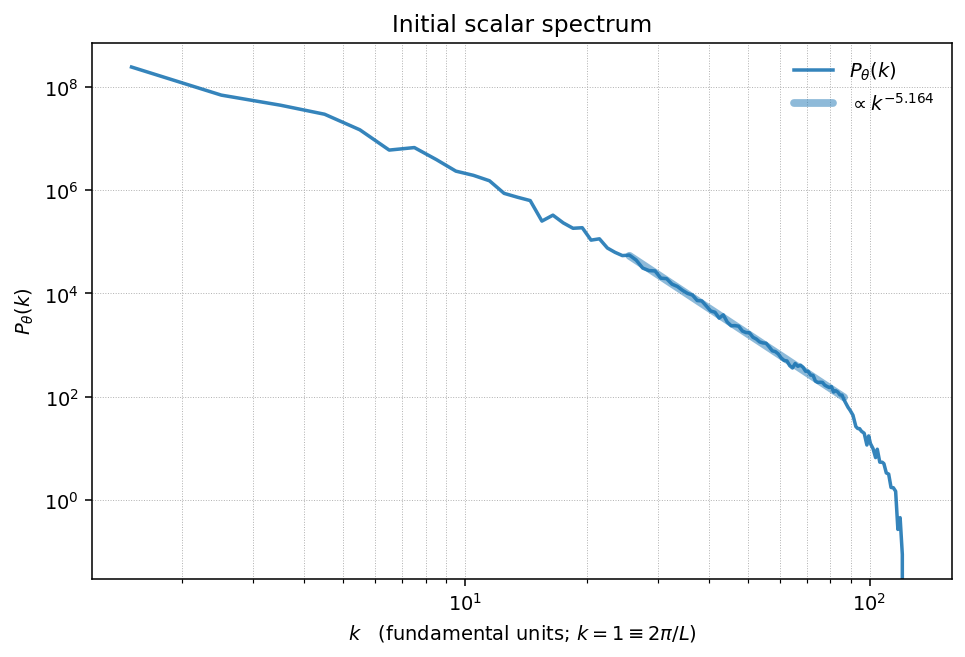

In [17]:
api.plot_scalar_spectrum(spec_final, title='Initial scalar spectrum')

The diagnostics object stores snapshots, frame sequences, and scalars such as time step and diffusivity. Use them to build your own analysis pipelines.